In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
import scipy.fftpack

In [4]:

seuil_detection_fitness=0.005

def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[-1] # JJ   attention, pb à régler un jour!
    return res

def analyse_fichier(): # ressort [W_t pour tout t] pour le fichier lu
    wt_tot=[]
    wt_cur=[]
    with open("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv", newline='') as csvfile:
        reader=csv.reader(csvfile,delimiter=';')
        nrow=0
        for row in reader:
            if(nrow>=2):
                wt_cur=analyse_ligne(row)
                wt_tot+=[wt_cur]
            nrow+=1
    return wt_tot

In [5]:

wt_real=np.array(analyse_fichier())
wt_real=wt_real[3:,:] # il faut supprimer les deux 1res.
with open('wt_sim.npy', 'rb') as f:
    wt_sim = np.load(f)


In [6]:
# (COMMENTER POUR TRAVAILLER SUR LES VRAIES DONNÉES)
wt_real=np.array(wt_sim)

In [7]:

# On considère W_t/W_0: <-- pose des problèmes pour les données observées
#for i in range(len(wt_real[0,:])):
#    if(wt_real[0,i]!=0):
#        wt_real[:,i]=wt_real[:,i]/wt_real[0,i]
#    else:
#         wt_real[:,i]=wt_real[:,i]*0


In [8]:
    
def fonction(x):
    return -np.cos(2*x)+0.5*np.cos(5*x)


def fourier_inverse(x,xi,Ff):
    res=[]
    n=len(Ff)
    for xp in x:
        fx=0
        for i in range(n):
            fx+=Ff[i]*np.exp(1j*xp*xi[i])
        res+=[fx/n]
    return res

def get_fourier_wt(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        ntot=0
        Ffx=0
        for i in range(n):
            if(wt[i]>0.001):
                Ffx+=np.exp(-1j*xip*np.log(wt[i]))
                ntot+=1
        res+=[Ffx/ntot]
    return res

def get_dt(prec,nouv):
    res=[]
    for i in range(len(prec)):
        res+=[nouv[i]-prec[i]]
    return res


In [12]:
ximin=1
ximax=100
xipp=10
nbreaks_xi=5

tmax=200

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


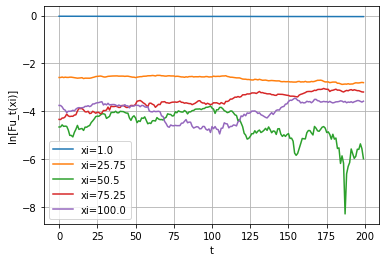

In [13]:

#x=np.linspace(xmin,xmax,nbreaks_x)
xi=np.linspace(ximin,ximax,nbreaks_xi)

tot=[]

for t in range(tmax):
    #print(t) # pour patienter (car c'est un peu long...)
    #Fu_t=get_fourier_wt([xipp],wt_real[t])
    Fu_t=get_fourier_wt(xi,wt_real[t])
    tot+=[np.log(np.array(Fu_t))]
tot=np.array(tot)

plt.plot(range(tmax),tot)
plt.grid()
plt.legend(["xi="+str(xip) for xip in xi])
plt.xlabel("t")
plt.ylabel("ln[Fu_t(xi)]")
plt.show()